# Wordle Solver

### Data: https://www.kaggle.com/datasets/bcruise/wordle-valid-words

In [116]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
random.seed(42)

df_solutions = pd.read_csv('valid_solutions.csv')
word_list = df_solutions['word'].tolist()

In [39]:
def print_stats(data):
    df = pd.DataFrame(data, columns=['guesses_num'])
    print(df.describe()[1:])
    
def vis_stats(arrays, names, log_x=False, log_y=False, x_range=None, data_type='hist', filename='fig.png', binwidth=1):
    df_compare = pd.DataFrame(
        np.array(
            arrays,
            dtype=np.float32
        ).T,
        columns=[*names]
    )
    plot = None
    if data_type == 'hist':
        plot = sns.displot(df_compare, palette='rocket', binwidth=binwidth, kind=data_type)
    elif data_type == 'ecdf':
        plot = sns.displot(df_compare, palette='rocket', kind=data_type)
    plt.xlabel('Number of guesses')
    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')
    if x_range:
        plt.xlim(x_range)
    plt.title('Number of guesses distribution')
    plot.savefig(filename, dpi=600)
    plt.close()

def show_stats(arrays, names, log_x=False, log_y=False, x_range=None, binwidth=1):
    _, ax = plt.subplots(1, 2, figsize=(25, 10))
    vis_stats(
        arrays=arrays,
        names=names,
        log_x=log_x,
        log_y=log_y,
        x_range=x_range,
        filename='hist.png',
        binwidth=binwidth
    )
    vis_stats(
        arrays=arrays,
        names=names,
        log_x=log_x,
        log_y=log_y,
        x_range=x_range,
        filename='ecdf.png',
        data_type='ecdf',
        binwidth=binwidth
    )
    
    ax[0].imshow(plt.imread('hist.png'))
    ax[0].axis('off')
    ax[1].imshow(plt.imread('ecdf.png'))
    ax[1].axis('off')
    
    plt.show()
    
def performance(name, array):
    guessed_words = array[array <= 6]
    coef = str(round(100 * len(guessed_words) / len(array), 2)).ljust(5, '0')
    space_gap_1 = 6 - len(str(len(guessed_words)))
    space_gap_2 = 1 if len(str(round(np.mean(array), 2))) == 4 else 0
    print(f"{name} performance:")
    print(f"{coef}% - Percentage of words guessed in 6 guesses")
    print(f"{len(guessed_words)}{' ' * space_gap_1} - Number of guessed words")
    print(f"{round(np.mean(array), 3)}{' ' * space_gap_2} - Avarage number of guesses ")
    print(f"{np.max(array)} - Max number of guesses")


# Algorithm Validator

In [3]:
class Algorithm:
    CORRECT_POSITION = 0
    WRONG_POSITION = 1
    NOT_IN_WORD = 2
    
    def __init__(self, word_list):
        self.word_list = word_list

    @staticmethod
    def validate_ans(ans: str, word: str):
        output = [Algorithm.NOT_IN_WORD for _ in range(len(word))]
        new_ans = ''
        new_word = ''
        new_idx = []
        
        for i in range(len(word)):
            if ans[i] == word[i]:
                output[i] = Algorithm.CORRECT_POSITION
            else:
                new_ans += ans[i]
                new_word += word[i]
                new_idx.append(i)
                
        for i in range(len(new_ans)):
            if new_ans[i] in new_word and new_ans[:i].count(new_ans[i]) < new_word.count(new_ans[i]):
                output[new_idx[i]] = Algorithm.WRONG_POSITION
        
        return output
    
    def validate_algorithm(self, show_loop: bool=True, **kwargs):
        guesses_stats = []
        word_list = self.word_list
        
        for word in tqdm(
            word_list,
            desc='Validating algorithm',
            total=len(word_list),
            bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
            unit='guessed words'
            ) if show_loop else word_list:
            
            guesses_num = 0
            answer_list, answer_info = [], []
            possible_words = deepcopy(word_list)
            
            while True:
                guess, possible_words = self.f(
                    answer_list, 
                    answer_info, 
                    possible_words=possible_words, 
                    **kwargs
                    )
                answer_list.append(guess)
                answer_info.append(Algorithm.validate_ans(ans=guess, word=word))
                guesses_num += 1
                if guess == word:
                    guesses_stats.append(guesses_num)
                    break
                
        return guesses_stats

    def f(self, ans, ans_info, possible_words, **kwargs): ...


In [4]:
assert Algorithm.validate_ans(ans='aabaa', word='ababa') == [
    Algorithm.CORRECT_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.NOT_IN_WORD,
    Algorithm.CORRECT_POSITION
    ]
assert Algorithm.validate_ans('aabad', 'ababa') == [
    Algorithm.CORRECT_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.NOT_IN_WORD
    ]
assert Algorithm.validate_ans('ababa', 'ababa') == [
    Algorithm.CORRECT_POSITION,
    Algorithm.CORRECT_POSITION,
    Algorithm.CORRECT_POSITION,
    Algorithm.CORRECT_POSITION,
    Algorithm.CORRECT_POSITION
    ]
assert Algorithm.validate_ans('ababa', 'babab') == [
    Algorithm.WRONG_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.NOT_IN_WORD
    ]
assert Algorithm.validate_ans('bbbbb', 'aaaaa') == [
    Algorithm.NOT_IN_WORD,
    Algorithm.NOT_IN_WORD,
    Algorithm.NOT_IN_WORD,
    Algorithm.NOT_IN_WORD,
    Algorithm.NOT_IN_WORD
    ]

## Random Algorithm (Baseline)

In [5]:
class RA(Algorithm):
    def f(self, ans, ans_info, possible_words, **kwargs):
        possible_words = list(set(possible_words) - set(ans))
        if len(ans) > 0:
            words_with_correct_position = []
            for word in possible_words:
                add_word = True
                for i in range(len(ans[-1])):
                    if ans_info[-1][i] == Algorithm.CORRECT_POSITION and ans[-1][i] != word[i]:
                        add_word = False
                        break
                if add_word:
                    words_with_correct_position.append(word)
            return possible_words[0], words_with_correct_position
        else:
            return possible_words[0], possible_words

In [6]:
ra_stats = np.array(RA(word_list).validate_algorithm()).T

Validating algorithm: 100%|████████████████████| 2315/2315 [00:09<00:00, 247.67guessed words/s]


In [7]:
arrays, names = [ra_stats], ['ra_guess']
performance('Random Algorithm', ra_stats)

Random Algorithm performance:
10.28% - Percentage of words guessed in 6 guesses
238    - Number of guessed words
12.766 - Avarage number guesses 


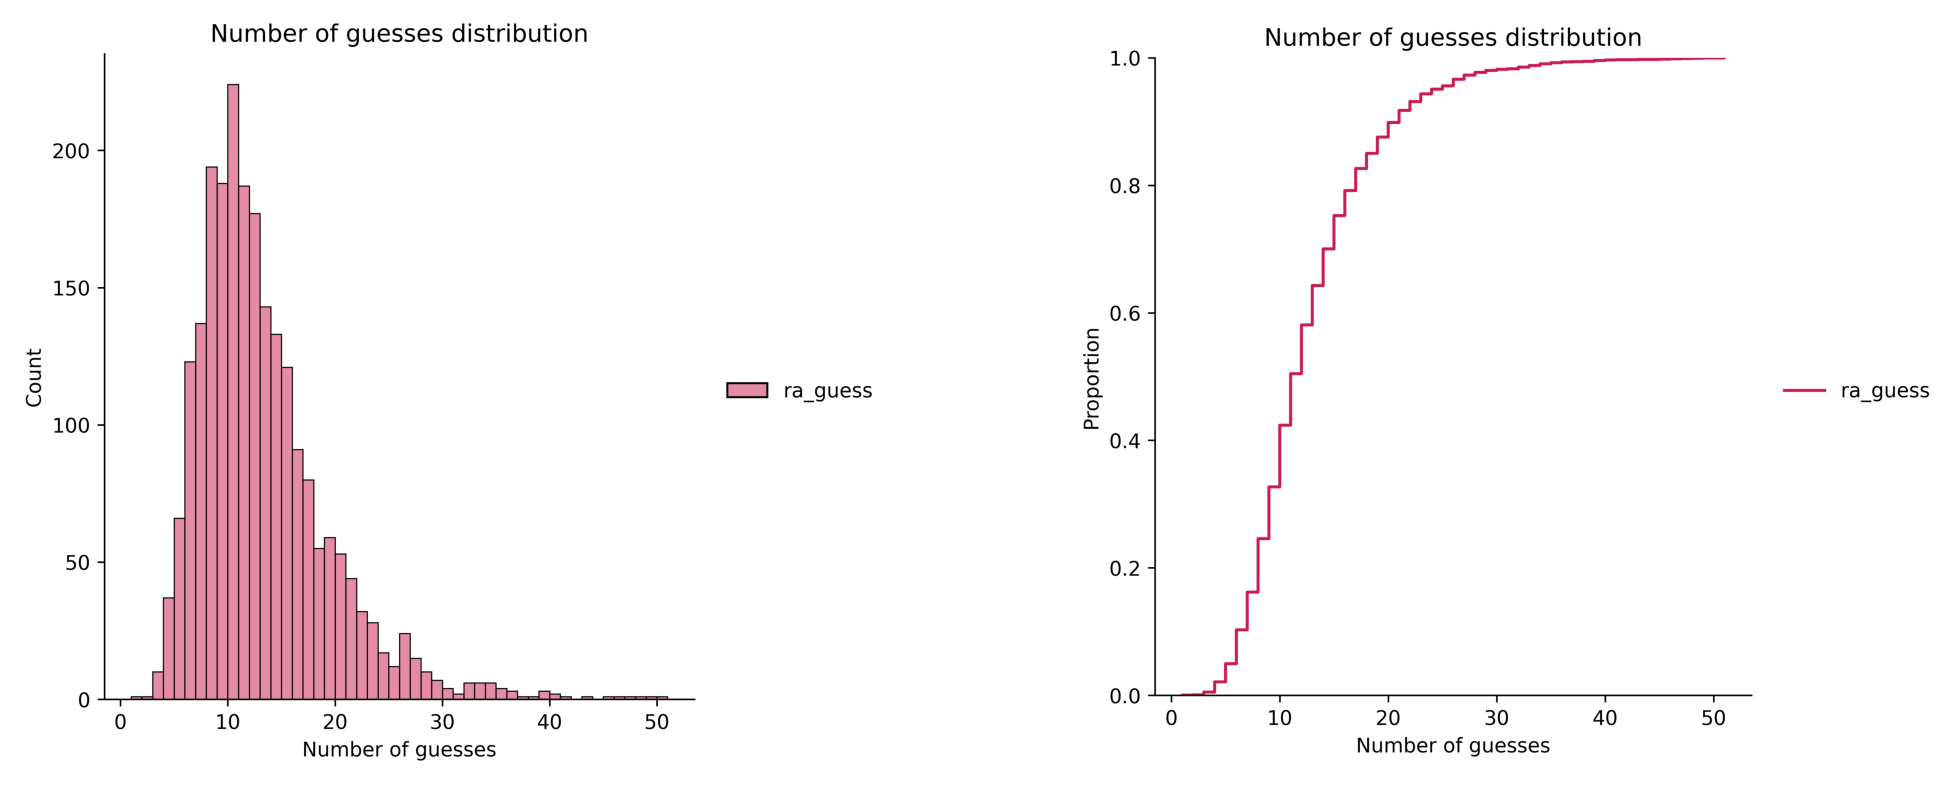

In [8]:
show_stats(arrays, names)

## Random Algorithm with Answer Recudction

In [9]:
class RAAR(Algorithm):
    def f(self, ans, ans_info, possible_words, **kwargs):
        if len(ans) > 0:
            possible_words = [
                word for word in possible_words 
                if Algorithm.validate_ans(ans[-1], word) == ans_info[-1]
            ]
        return possible_words[0], possible_words

In [10]:
raar_stats = np.array(RAAR(word_list).validate_algorithm()).T

Validating algorithm: 100%|████████████████████| 2315/2315 [00:11<00:00, 199.37guessed words/s]


In [40]:
performance('Random Algorithm with Answer Removal', raar_stats)

Random Algorithm with Answer Removal performance:
97.49% - Percentage of words guessed in 6 guesses
2257   - Number of guessed words
4.349  - Avarage number of guesses 
9 - Max number of guesses


In [12]:
arrays.append(raar_stats)
names.append('raar_guess')

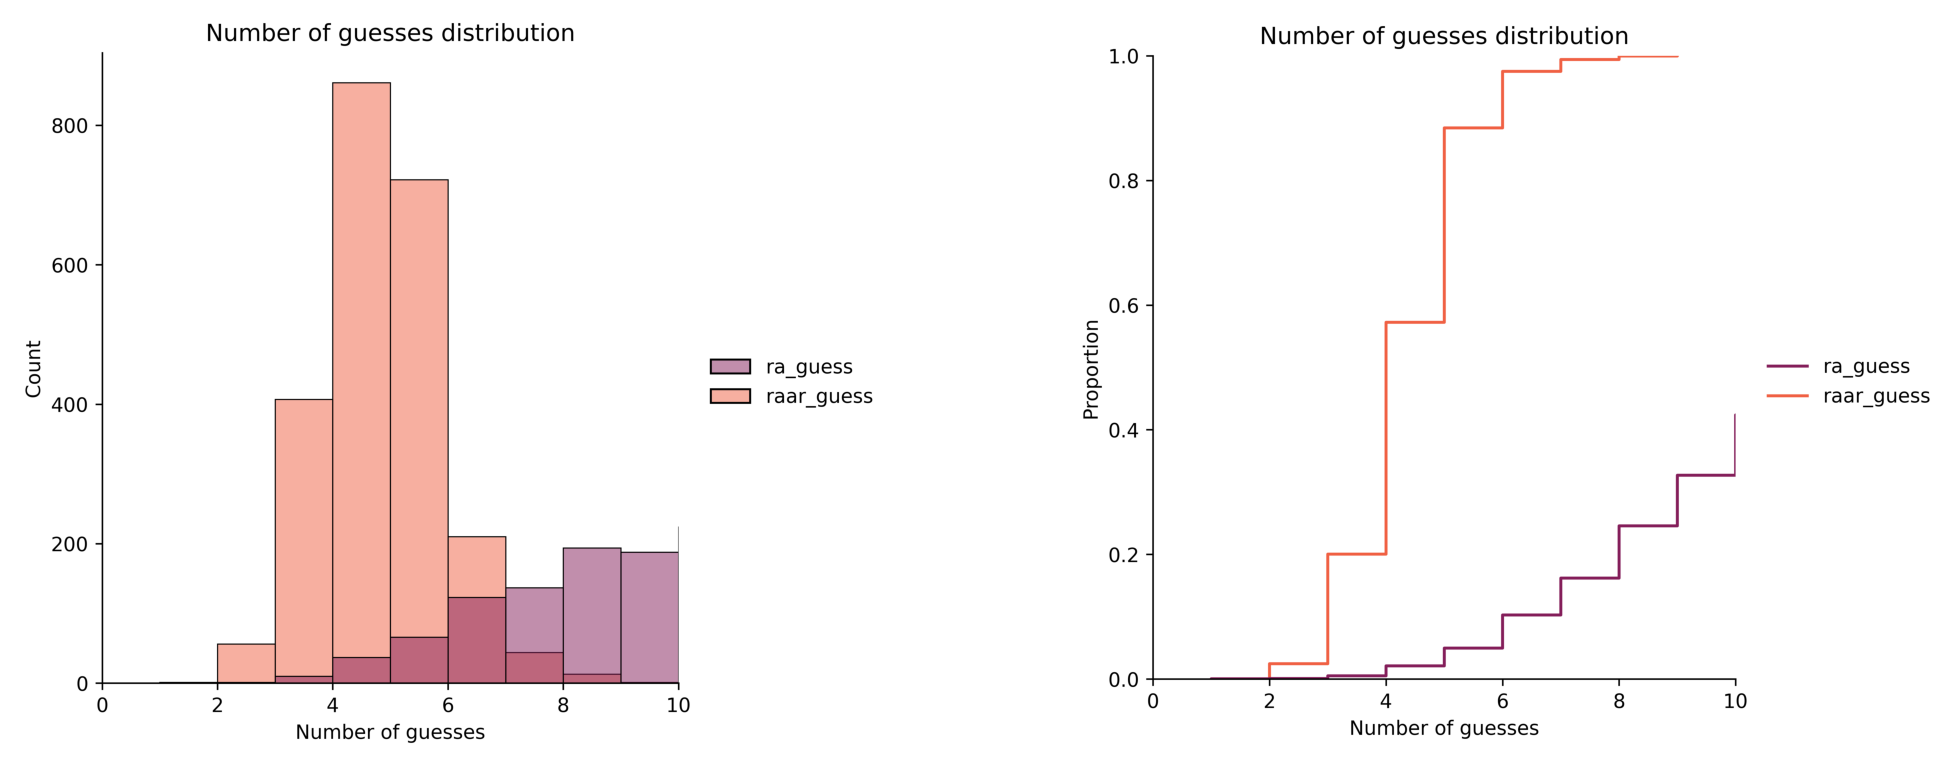

In [13]:
show_stats(arrays, names, x_range=(0, 10))

## Reducing Randomness by Words Frequency

In [42]:
class RRWF(Algorithm):
    def f(self, ans, ans_info, possible_words, **kwargs):
        if len(ans) > 0:
            possible_words = [
                word for word in possible_words 
                if Algorithm.validate_ans(ans[-1], word) == ans_info[-1]
            ]
            
        apperance_tab = np.zeros([26, 5])
        for word in possible_words:
            for i in range(len(word)):
                apperance_tab[ord(word[i]) - ord('a'), i] += 1
                
        top_prediction = None
        top_score = 0
        for word in possible_words:
            score = 0
            for i in range(len(word)):
                score += apperance_tab[ord(word[i]) - ord('a'), i]
            if score > top_score:
                top_score = score
                top_prediction = word
        
        return top_prediction, possible_words

In [43]:
rrwf_stats = np.array(RRWF(word_list).validate_algorithm()).T

Validating algorithm: 100%|████████████████████| 2315/2315 [00:21<00:00, 105.32guessed words/s]


In [44]:
performance('Reducing Randomness by Word Frequency', rrwf_stats)

Reducing Randomness by Word Frequency performance:
99.40% - Percentage of words guessed in 6 guesses
2301   - Number of guessed words
3.641  - Avarage number of guesses 
8 - Max number of guesses


In [45]:
arrays.append(rrwf_stats)
names.append('rrwf_guess')

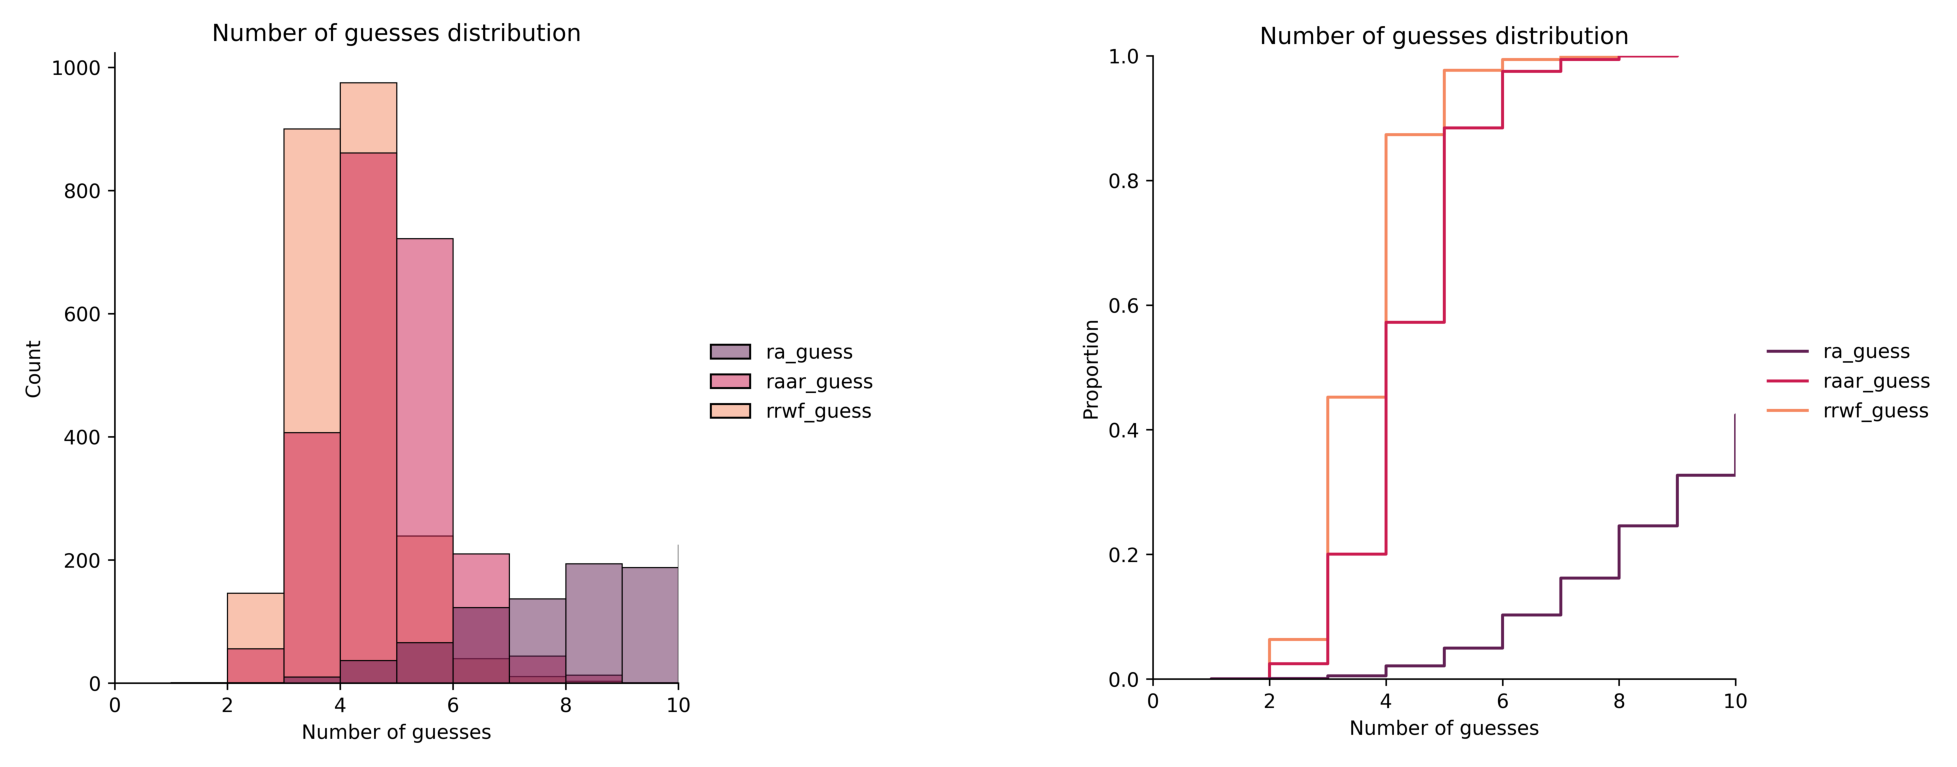

In [18]:
show_stats(arrays, names, x_range=(0, 10))

## Finite Automat

In [113]:
class FA(Algorithm):
    @staticmethod
    def to_decimal(ans_info):
        output = 0
        for i in range(len(ans_info)):
            output += ans_info[i] * 3 ** i
        return output
    
    @staticmethod
    def find_the_best_split(possible_words, loss_function, show_loop=False):
        top_word = None
        top_score = float('inf')
        for word in tqdm(
            possible_words,
            desc='Finding the best split',
            total=len(possible_words),
            bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
            unit='checked words'
            ) if show_loop else possible_words:
            apperance_tab = np.ndarray([3 ** 5])
            score = float('inf')
            
            for guess in possible_words:
                apperance_tab[FA.to_decimal(Algorithm.validate_ans(guess, word))] += 1
                
            apperance_tab = np.array([apperance_tab[i] if i in apperance_tab else 0 for i in range(3 ** 5)])
            score = min(score, loss_function(apperance_tab))
                    
            if score < top_score:
                top_score = score
                top_word = word
                
        return top_word, top_score
        
    def f(self, ans, ans_info, possible_words, loss_function, **kwargs):
        if len(ans) == 0:
            return kwargs['starting_word'], possible_words
         
        possible_words = [
            word for word in possible_words 
            if Algorithm.validate_ans(ans[-1], word) == ans_info[-1]
        ]
            
        top_word = self.find_the_best_split(possible_words, loss_function=loss_function, show_loop=False)[0]
        
        return top_word, list(set(possible_words) - set(top_word))

In [117]:
f1 = lambda x: np.power(x, 2)
g1 = lambda x: np.sum(f1(x))
first_word, score = FA.find_the_best_split(word_list, loss_function=g1, show_loop=True)
fa_stats_1 = np.array(FA(word_list).validate_algorithm(starting_word=first_word, loss_function=g1)).T
performance('Finite Automat', fa_stats_1)

Finding the best split: 100%|████████████████████| 2315/2315 [00:15<00:00, 147.35checked words/s]


('drill', 18.0)

In [ ]:
f1 = lambda x: np.power(x, 2)
g1 = lambda x: np.sum(f1(x))
first_word, score = FA.find_the_best_split(word_list, loss_function=g1, show_loop=True)
fa_stats_1 = np.array(FA(word_list).validate_algorithm(starting_word=first_word, loss_function=g1)).T
performance('Finite Automat', fa_stats_1)

In [ ]:
f1 = lambda x: np.power(x, 2)
g1 = lambda x: np.sum(f1(x))
first_word, score = FA.find_the_best_split(word_list, loss_function=g1, show_loop=True)
fa_stats_1 = np.array(FA(word_list).validate_algorithm(starting_word=first_word, loss_function=g1)).T
performance('Finite Automat', fa_stats_1)

In [37]:
arrays.append(fa_stats)
names.append('fa_guess')

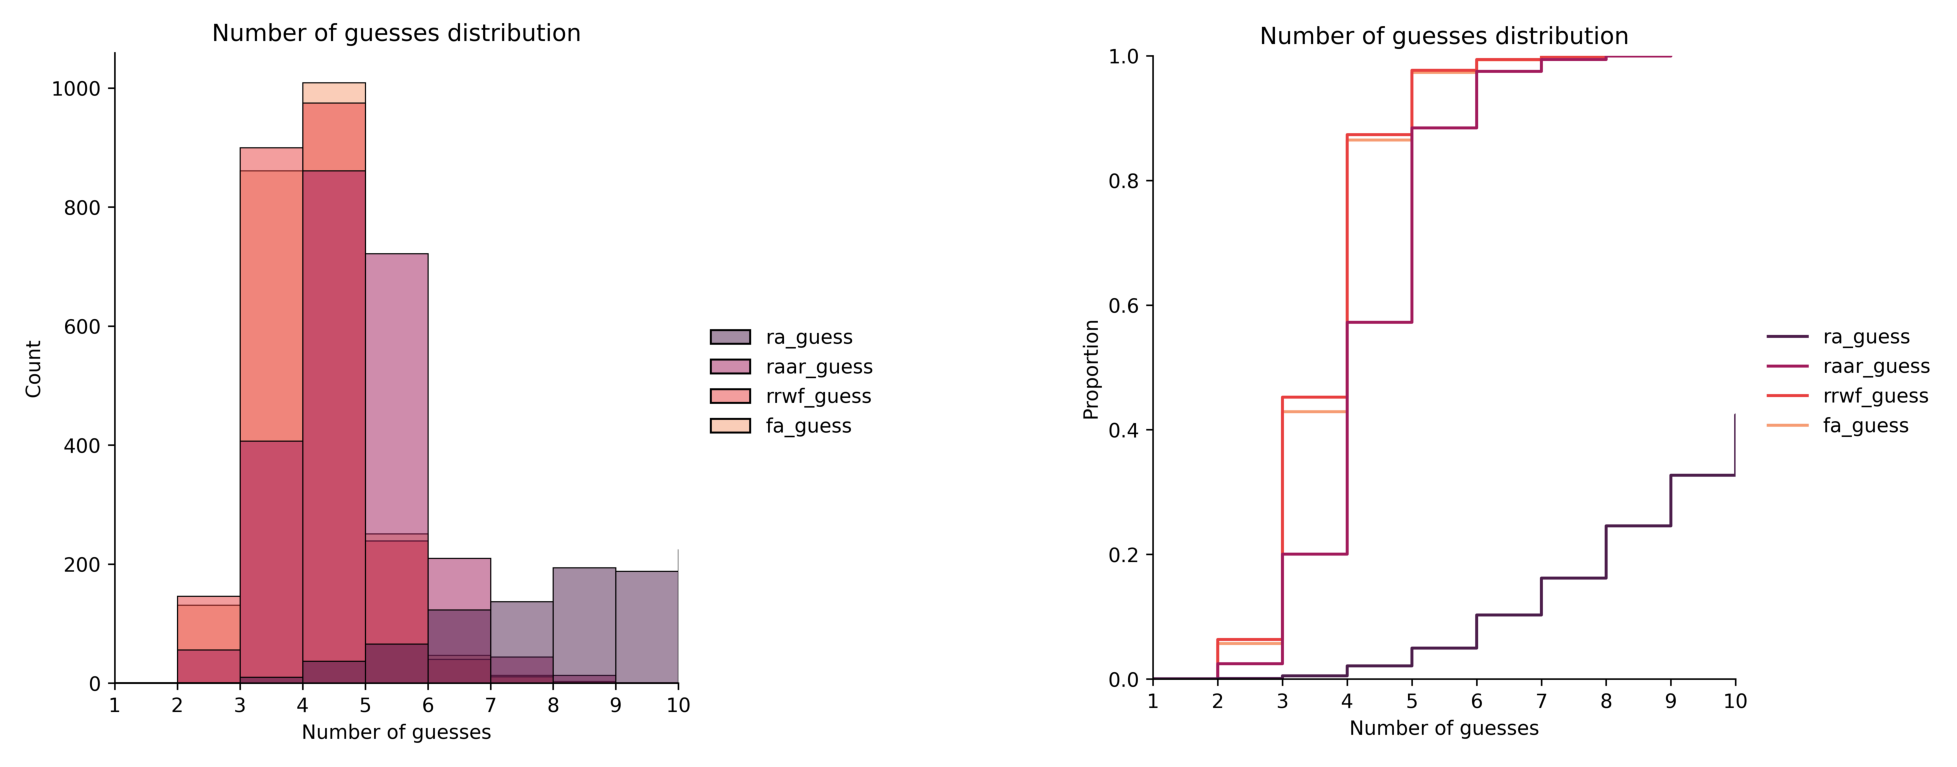

In [38]:
show_stats(arrays, names, x_range=(1, 10))

In [ ]:
f"The best word is: {top_word}"

'The best word is: abase'